Daniel Lizano Morales C04285

Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Ariel Solís

In [38]:
import os
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import wandb
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
#no ejecuten esta celda a menos de que vayan a entrenar
wandb.login(key=os.getenv('WANDB_KEY'))

In [ ]:
import ssl

#Deshabilitar verificación SSL
ssl._create_default_https_context = ssl._create_unverified_context

### CNN con imágenes crudas

In [44]:
wandb.init(project='cnn_original_images_bw', name='Original Images BW')
base_dir_original = 'COVID-19_Radiography_Dataset'

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=240, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) 
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1), 
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [50]:
train_dir_original = os.path.join(base_dir_original, 'train')
val_dir_original = os.path.join(base_dir_original, 'val')
os.makedirs(train_dir_original, exist_ok=True)
os.makedirs(val_dir_original, exist_ok=True)

In [51]:
if not os.listdir(train_dir_original) or not os.listdir(val_dir_original):
    # Copy data to the correct directories if not already done
    for category in ['Viral_Pneumonia', 'COVID', 'Normal', 'Lung_Opacity']:
        category_path = os.path.join(base_dir_original, category, 'images')
        images = os.listdir(category_path)

        # Ensure the category directories exist in train and val directories
        train_category_dir = os.path.join(train_dir_original, category)
        val_category_dir = os.path.join(val_dir_original, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(val_category_dir, exist_ok=True)
        train_images = images[:int(len(images) * 0.8)]
        val_images = images[int(len(images) * 0.8):]
        for img in tqdm(train_images, desc=f"Copying train images for {category}"):
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(train_category_dir, img)
            if not os.path.exists(dst_path):
                shutil.copy(src_path, dst_path)
        for img in tqdm(val_images, desc=f"Copying val images for {category}"):
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(val_category_dir, img)
            if not os.path.exists(dst_path):
                shutil.copy(src_path, dst_path)

print("\nTrain Directory Structure:")
for root, dirs, files in os.walk(train_dir_original):
    print(root, "contains", len(files), "files")

print("\nValidation Directory Structure:")
for root, dirs, files in os.walk(val_dir_original):
    print(root, "contains", len(files), "files")

Copying val images for Lung_Opacity: 100%|██████████| 1203/1203 [00:02<00:00, 433.68it/s]



Train Directory Structure:
COVID-19_Radiography_Dataset\train contains 0 files
COVID-19_Radiography_Dataset\train\COVID contains 2892 files
COVID-19_Radiography_Dataset\train\Lung_Opacity contains 4809 files
COVID-19_Radiography_Dataset\train\Normal contains 8153 files
COVID-19_Radiography_Dataset\train\Viral_Pneumonia contains 1076 files

Validation Directory Structure:
COVID-19_Radiography_Dataset\val contains 0 files
COVID-19_Radiography_Dataset\val\COVID contains 724 files
COVID-19_Radiography_Dataset\val\Lung_Opacity contains 1203 files
COVID-19_Radiography_Dataset\val\Normal contains 2039 files
COVID-19_Radiography_Dataset\val\Viral_Pneumonia contains 269 files


In [52]:
train_dataset_original = datasets.ImageFolder(train_dir_original, transform=data_transforms['train'])
val_dataset_original = datasets.ImageFolder(val_dir_original, transform=data_transforms['val'])
train_loader_original = DataLoader(train_dataset_original, batch_size=32, shuffle=True)
val_loader_original = DataLoader(val_dataset_original, batch_size=32, shuffle=False)

In [53]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_original = EfficientNet.from_pretrained('efficientnet-b1')
num_classes_original = len(train_dataset_original.classes)
model_original._conv_stem = nn.Conv2d(1, model_original._conv_stem.out_channels, 
                             kernel_size=model_original._conv_stem.kernel_size, 
                             stride=model_original._conv_stem.stride, 
                             padding=model_original._conv_stem.padding, 
                             bias=False)
model_original._fc = nn.Linear(model_original._fc.in_features, num_classes_original)
model_original = model_original.to(device)
criterion_original = nn.CrossEntropyLoss()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to C:\Users\ISRAEL/.cache\torch\hub\checkpoints\efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:01<00:00, 24.4MB/s]


Loaded pretrained weights for efficientnet-b1


In [54]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model_save_path = 'COVID-19_Radiography_Dataset/models/best_model_original_bw.pth'
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        #Training phase with progress bar
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_progress.set_postfix({"Loss": running_loss / total, "Acc": correct / total})
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        #Log training metrics
        wandb.log({"epoch": epoch + 1, "train_loss": epoch_loss, "train_accuracy": epoch_acc})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        #Log validation metrics
        wandb.log({"epoch": epoch + 1, "val_loss": val_loss, "val_accuracy": val_acc})

        #Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)  # Save the best model
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    return model


In [55]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [56]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    cm_figure = plot_confusion_matrix(cm, class_names=dataloader.dataset.classes)
    wandb.log({"confusion_matrix_eval": wandb.Image(cm_figure)})

    #Print and show the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix - Evaluation')
    plt.show()
    print(f'Accuracy: {accuracy:.4f}')

    return accuracy


Epoch 1/20 - Training: 100%|██████████| 530/530 [10:49<00:00,  1.23s/batch, Loss=0.407, Acc=0.853]


Epoch 1/20
Train Loss: 0.4070 Acc: 0.8527
Val Loss: 0.7719 Acc: 0.7773


Epoch 2/20 - Training: 100%|██████████| 530/530 [08:37<00:00,  1.02batch/s, Loss=0.271, Acc=0.903]


Epoch 2/20
Train Loss: 0.2705 Acc: 0.9025
Val Loss: 0.2603 Acc: 0.9048


Epoch 3/20 - Training: 100%|██████████| 530/530 [08:47<00:00,  1.00batch/s, Loss=0.225, Acc=0.922]


Epoch 3/20
Train Loss: 0.2255 Acc: 0.9216
Val Loss: 0.2906 Acc: 0.9136


Epoch 4/20 - Training: 100%|██████████| 530/530 [08:42<00:00,  1.02batch/s, Loss=0.198, Acc=0.928]


Epoch 4/20
Train Loss: 0.1978 Acc: 0.9281
Val Loss: 0.2462 Acc: 0.9237


Epoch 5/20 - Training: 100%|██████████| 530/530 [08:01<00:00,  1.10batch/s, Loss=0.186, Acc=0.935]


Epoch 5/20
Train Loss: 0.1860 Acc: 0.9351
Val Loss: 0.2105 Acc: 0.9249


Epoch 6/20 - Training: 100%|██████████| 530/530 [07:34<00:00,  1.17batch/s, Loss=0.183, Acc=0.935]


Epoch 6/20
Train Loss: 0.1834 Acc: 0.9351
Val Loss: 0.2029 Acc: 0.9367


Epoch 7/20 - Training: 100%|██████████| 530/530 [07:36<00:00,  1.16batch/s, Loss=0.163, Acc=0.941]


Epoch 7/20
Train Loss: 0.1634 Acc: 0.9405
Val Loss: 0.1734 Acc: 0.9424


Epoch 8/20 - Training: 100%|██████████| 530/530 [07:34<00:00,  1.17batch/s, Loss=0.157, Acc=0.944]


Epoch 8/20
Train Loss: 0.1572 Acc: 0.9441
Val Loss: 0.3861 Acc: 0.8597


Epoch 9/20 - Training: 100%|██████████| 530/530 [07:34<00:00,  1.17batch/s, Loss=0.144, Acc=0.949]


Epoch 9/20
Train Loss: 0.1439 Acc: 0.9494
Val Loss: 0.1797 Acc: 0.9443


Epoch 10/20 - Training: 100%|██████████| 530/530 [07:33<00:00,  1.17batch/s, Loss=0.142, Acc=0.949]


Epoch 10/20
Train Loss: 0.1420 Acc: 0.9490
Val Loss: 0.2219 Acc: 0.9268
Early stopping triggered!


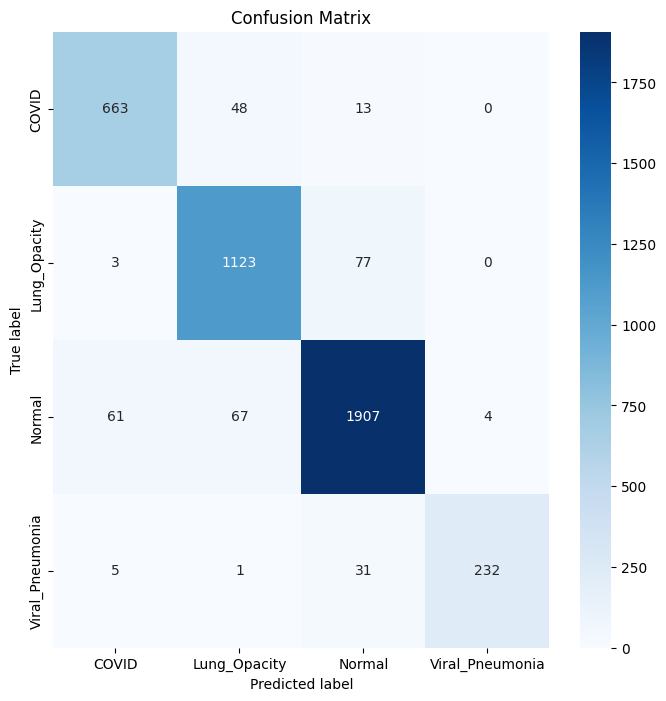

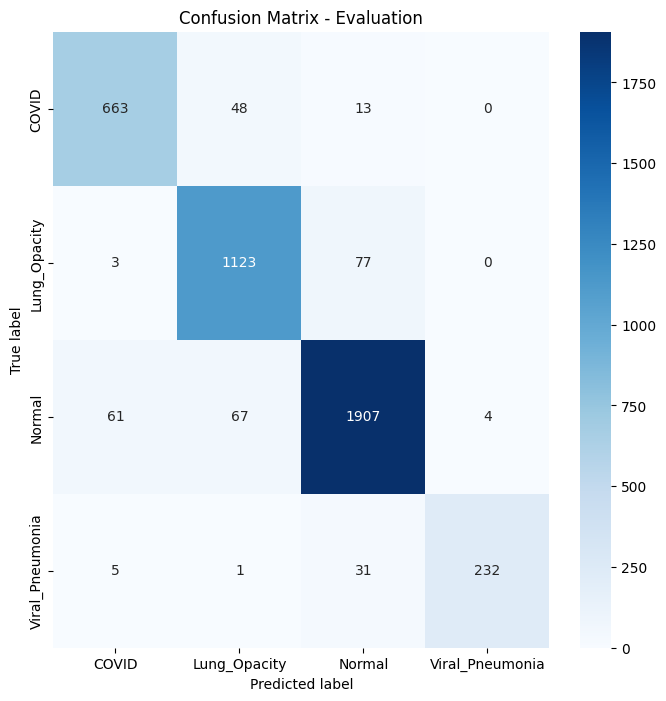

Accuracy: 0.9268


0.9268004722550177

In [57]:
trained_model_original = train_model(model_original, criterion_original, optimizer_original, train_loader_original, val_loader_original, device, num_epochs=20, patience=3)

In [ ]:
evaluate_model(trained_model_original, val_loader_original, device)

### CNN con imágenes filtradas


In [58]:
wandb.init(project='cnn_filtered_images_bw', name='Filtered Images BW')
base_dir_filtered = 'COVID-19_Radiography_Dataset/filtradas'

epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▇▇▇██▄█▇
val_loss,█▂▂▂▁▁▁▃▁▂
epoch,10
train_accuracy,0.94897
train_loss,0.14197
val_accuracy,0.9268
val_loss,0.22189


In [59]:
data_transforms_filtered = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=240, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [60]:
train_dir_filtered = os.path.join(base_dir_filtered, 'train')
val_dir_filtered = os.path.join(base_dir_filtered, 'val')
os.makedirs(train_dir_filtered, exist_ok=True)
os.makedirs(val_dir_filtered, exist_ok=True)

In [61]:
#Check if train and val directories are already populated
if not os.listdir(train_dir_filtered) or not os.listdir(val_dir_filtered):
    #Copy data to the correct directories if not already done
    for category in ['Viral_Pneumonia', 'COVID', 'Normal', 'Lung_Opacity']:
        category_path = os.path.join(base_dir_filtered, category)
        images = os.listdir(category_path)
        train_category_dir = os.path.join(train_dir_filtered, category)
        val_category_dir = os.path.join(val_dir_filtered, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(val_category_dir, exist_ok=True)
        train_images = images[:int(len(images) * 0.8)]
        val_images = images[int(len(images) * 0.8):]
        for img in tqdm(train_images, desc=f"Copying train images for {category}"):
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(train_category_dir, img)
            if not os.path.exists(dst_path):
                shutil.copy(src_path, dst_path)
        for img in tqdm(val_images, desc=f"Copying val images for {category}"):
            src_path = os.path.join(category_path, img)
            dst_path = os.path.join(val_category_dir, img)
            if not os.path.exists(dst_path):
                shutil.copy(src_path, dst_path)

print("\nTrain Directory Structure (Filtered):")
for root, dirs, files in os.walk(train_dir_filtered):
    print(root, "contains", len(files), "files")
print("\nValidation Directory Structure (Filtered):")
for root, dirs, files in os.walk(val_dir_filtered):
    print(root, "contains", len(files), "files")



Train Directory Structure (Filtered):
COVID-19_Radiography_Dataset/filtradas\train contains 0 files
COVID-19_Radiography_Dataset/filtradas\train\Covid contains 2892 files
COVID-19_Radiography_Dataset/filtradas\train\Lung_Opacity contains 4809 files
COVID-19_Radiography_Dataset/filtradas\train\Normal contains 8153 files
COVID-19_Radiography_Dataset/filtradas\train\Viral_Pneumonia contains 1076 files

Validation Directory Structure (Filtered):
COVID-19_Radiography_Dataset/filtradas\val contains 0 files
COVID-19_Radiography_Dataset/filtradas\val\Covid contains 724 files
COVID-19_Radiography_Dataset/filtradas\val\Lung_Opacity contains 1203 files
COVID-19_Radiography_Dataset/filtradas\val\Normal contains 2039 files
COVID-19_Radiography_Dataset/filtradas\val\Viral_Pneumonia contains 269 files


In [63]:
#load the datasets
train_dataset_filtered = datasets.ImageFolder(train_dir_filtered, transform=data_transforms_filtered['train'])
val_dataset_filtered = datasets.ImageFolder(val_dir_filtered, transform=data_transforms_filtered['val'])
train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=32, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=32, shuffle=False)

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_filtered = EfficientNet.from_pretrained('efficientnet-b1')
num_classes_filtered = len(train_dataset_filtered.classes)
model_filtered._conv_stem = nn.Conv2d(1, model_filtered._conv_stem.out_channels, 
                             kernel_size=model_filtered._conv_stem.kernel_size, 
                             stride=model_filtered._conv_stem.stride, 
                             padding=model_filtered._conv_stem.padding, 
                             bias=False)
model_filtered._fc = nn.Linear(model_filtered._fc.in_features, num_classes_filtered)
model_filtered = model_filtered.to(device)
criterion_filtered = nn.CrossEntropyLoss()
optimizer_filtered = torch.optim.Adam(model_filtered.parameters(), lr=0.001)

Loaded pretrained weights for efficientnet-b1


In [66]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model_save_path = 'COVID-19_Radiography_Dataset/models/best_model_filtered_bw.pth'
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        #Training phase with progress bar
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_progress.set_postfix({"Loss": running_loss / total, "Acc": correct / total})
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        #Log training metrics
        wandb.log({"epoch": epoch + 1, "train_loss": epoch_loss, "train_accuracy": epoch_acc})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        #Log validation metrics
        wandb.log({"epoch": epoch + 1, "val_loss": val_loss, "val_accuracy": val_acc})
        #Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)  # Save the best model
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    return model


In [67]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [68]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    cm_figure = plot_confusion_matrix(cm, class_names=dataloader.dataset.classes)
    wandb.log({"confusion_matrix_eval": wandb.Image(cm_figure)})

    #Print and show the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix - Evaluation')
    plt.show()
    print(f'Accuracy: {accuracy:.4f}')
    
    return accuracy

Epoch 1/20 - Training: 100%|██████████| 530/530 [10:24<00:00,  1.18s/batch, Loss=0.445, Acc=0.835]


Epoch 1/20
Train Loss: 0.4450 Acc: 0.8350
Val Loss: 0.5083 Acc: 0.8394


Epoch 2/20 - Training: 100%|██████████| 530/530 [08:24<00:00,  1.05batch/s, Loss=0.308, Acc=0.889]


Epoch 2/20
Train Loss: 0.3075 Acc: 0.8891
Val Loss: 0.2951 Acc: 0.9030


Epoch 3/20 - Training: 100%|██████████| 530/530 [08:29<00:00,  1.04batch/s, Loss=0.261, Acc=0.906]


Epoch 3/20
Train Loss: 0.2612 Acc: 0.9063
Val Loss: 0.2863 Acc: 0.9048


Epoch 4/20 - Training: 100%|██████████| 530/530 [09:17<00:00,  1.05s/batch, Loss=0.231, Acc=0.917]


Epoch 4/20
Train Loss: 0.2308 Acc: 0.9169
Val Loss: 0.2184 Acc: 0.9311


Epoch 5/20 - Training: 100%|██████████| 530/530 [09:21<00:00,  1.06s/batch, Loss=0.216, Acc=0.922]


Epoch 5/20
Train Loss: 0.2161 Acc: 0.9224
Val Loss: 0.2903 Acc: 0.9152


Epoch 6/20 - Training: 100%|██████████| 530/530 [09:08<00:00,  1.03s/batch, Loss=0.211, Acc=0.924]


Epoch 6/20
Train Loss: 0.2108 Acc: 0.9242
Val Loss: 0.3193 Acc: 0.9030


Epoch 7/20 - Training: 100%|██████████| 530/530 [09:30<00:00,  1.08s/batch, Loss=0.196, Acc=0.93] 


Epoch 7/20
Train Loss: 0.1956 Acc: 0.9296
Val Loss: 0.2131 Acc: 0.9294


Epoch 8/20 - Training: 100%|██████████| 530/530 [09:28<00:00,  1.07s/batch, Loss=0.185, Acc=0.931]


Epoch 8/20
Train Loss: 0.1850 Acc: 0.9313
Val Loss: 0.2716 Acc: 0.9115


Epoch 9/20 - Training: 100%|██████████| 530/530 [09:14<00:00,  1.05s/batch, Loss=0.198, Acc=0.929]


Epoch 9/20
Train Loss: 0.1977 Acc: 0.9294
Val Loss: 0.3462 Acc: 0.8916


Epoch 10/20 - Training: 100%|██████████| 530/530 [11:05<00:00,  1.26s/batch, Loss=0.165, Acc=0.94] 


Epoch 10/20
Train Loss: 0.1646 Acc: 0.9405
Val Loss: 0.1756 Acc: 0.9429


Epoch 11/20 - Training: 100%|██████████| 530/530 [15:34<00:00,  1.76s/batch, Loss=0.157, Acc=0.944]


Epoch 11/20
Train Loss: 0.1573 Acc: 0.9442
Val Loss: 0.2362 Acc: 0.9228


Epoch 12/20 - Training: 100%|██████████| 530/530 [14:27<00:00,  1.64s/batch, Loss=0.154, Acc=0.944]


Epoch 12/20
Train Loss: 0.1542 Acc: 0.9438
Val Loss: 0.2752 Acc: 0.9157


Epoch 13/20 - Training: 100%|██████████| 530/530 [12:45<00:00,  1.44s/batch, Loss=0.149, Acc=0.945]


Epoch 13/20
Train Loss: 0.1487 Acc: 0.9449
Val Loss: 0.3113 Acc: 0.9115
Early stopping triggered!


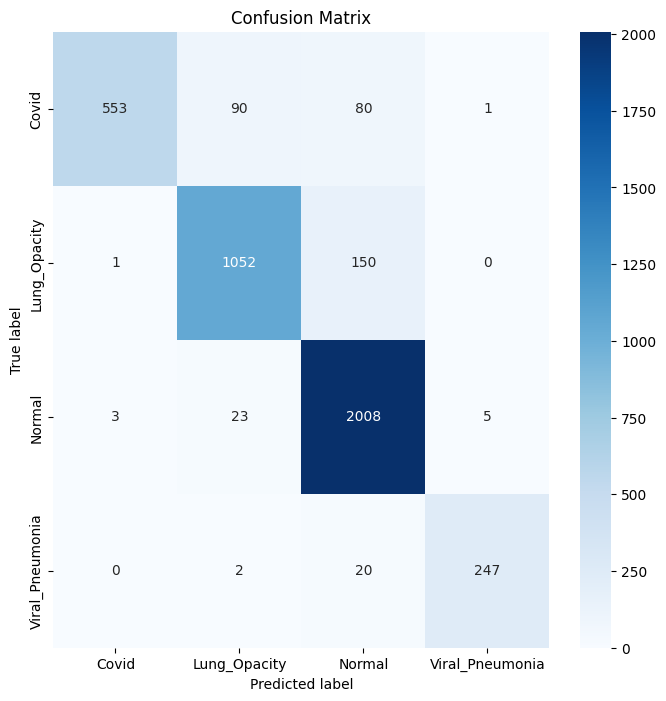

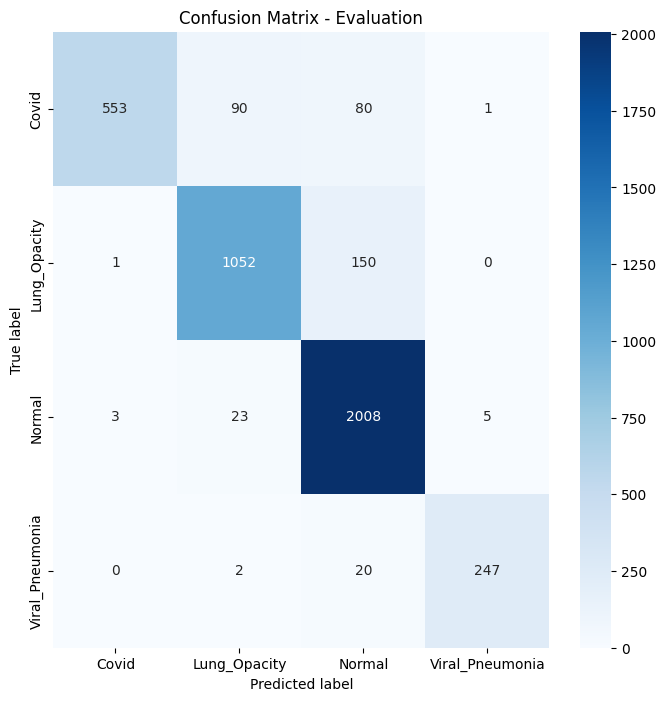

Accuracy: 0.9115


0.911452184179457

In [69]:
trained_model_filtered = train_model(model_filtered, criterion_filtered, optimizer_filtered, train_loader_filtered, val_loader_filtered, device, num_epochs=20, patience=3)
evaluate_model(trained_model_filtered, val_loader_filtered, device)

### Mapa de calor

In [74]:
model_load_path = 'COVID-19_Radiography_Dataset/models/best_model_filtered_bw.pth'
num_classes_filtered = 4

In [75]:
def load_model(model_path, num_classes):
    model = EfficientNet.from_pretrained('efficientnet-b1')
    model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, 
                                 kernel_size=model._conv_stem.kernel_size, 
                                 stride=model._conv_stem.stride, 
                                 padding=model._conv_stem.padding, 
                                 bias=False)
    model._fc = nn.Linear(model._fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    return model

In [76]:
model_filtered_loaded = load_model(model_load_path, num_classes_filtered).to(device)

Loaded pretrained weights for efficientnet-b1


In [77]:
model_filtered_loaded.eval()

EfficientNet(
  (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
        (static_padding): Identity()
      )
      (_bn2): BatchNorm2d(16, 

In [78]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(num_output_channels=1), 
])

In [79]:
img = Image.open('COVID-19_Radiography_Dataset/filtradas/Covid/COVID-1.png')
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0).to(device)
img_tensor.requires_grad = True

In [80]:
output = model_filtered_loaded(img_tensor)
score, predicted_class = torch.max(output, 1)
model_filtered_loaded.zero_grad()
score.backward()

In [81]:
saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
saliency = saliency.reshape(224, 224)

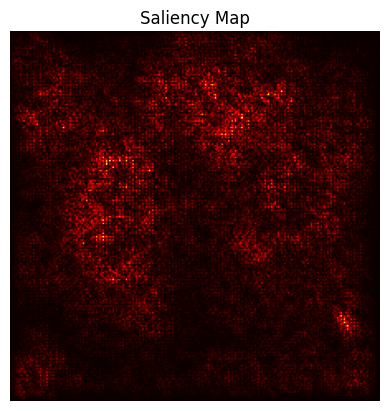

In [82]:
plt.imshow(saliency.cpu(), cmap='hot')
plt.axis('off')
plt.title('Saliency Map')
plt.show()